In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

# About the data

* Data about unemployment from Jan 1st 1948 to Jan 1st 2019
* Each data point is a month apart from each other
* The unemployment rate is a % measure
* Data is seasonally adjusted for by the contributers from FRED (Federal Reserve Economic Data)

For the purpose of this analysis, exogenous variables such as whether there is a recession or not is not included, but is accounted for in the original data and clearly affects the trends. For now, all we want to see is if previous unemployment rates can be used to forecast future unemployment rates.


* Plot the time series, along with any logical or necessary differences to get a stationary dataset
* Generate and interpret a PACF for the time series (and/or its differences)
* Generate 5 ARIMA specifications and evaluate their efficacy at modeling your data
* Finally choose one specification and make the case for that as a logical model for your dataset.

In [2]:
unrate_df = pd.read_csv('UNRATE.csv')
unrate_df.isnull().any()

DATE      False
UNRATE    False
dtype: bool

In [3]:
display(unrate_df.head())
unrate_df.dtypes

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


DATE       object
UNRATE    float64
dtype: object

In [4]:
unrate_df.DATE.dtype

dtype('O')

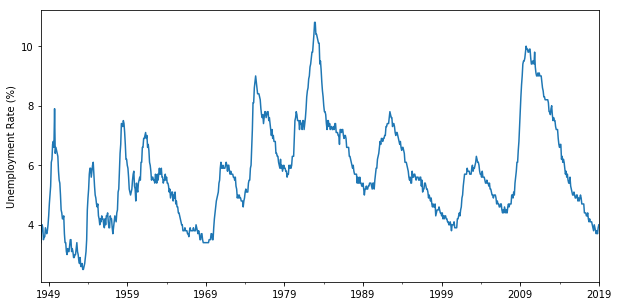

In [5]:
unrate_df.index = pd.DatetimeIndex(unrate_df['DATE'].values, freq=pd.infer_freq(pd.to_datetime(unrate_df['DATE'])))

unrate_df.UNRATE.plot(kind='line', figsize=(10,5))
plt.ylabel('Unemployment Rate (%)')
plt.show()

Clearly there is some linear trend present in this data, so lets try differencing of 1 and 2 to see if we can make the data stationary in order to satisfy one of the assumtpions of the ARIMA model.

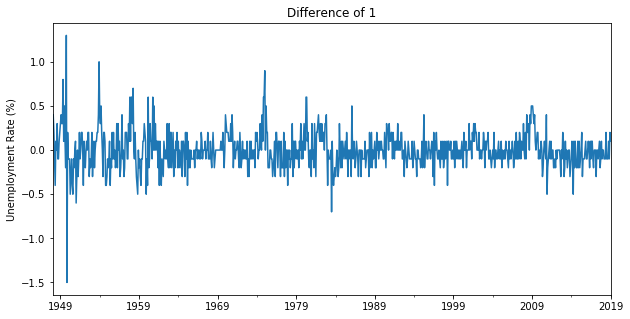

In [6]:
unrate_df['diff_1'] = unrate_df.UNRATE - unrate_df.UNRATE.shift()
unrate_df['diff_1'].plot(kind='line', figsize=(10,5), title='Difference of 1')
plt.ylabel('Unemployment Rate (%)')
plt.show()

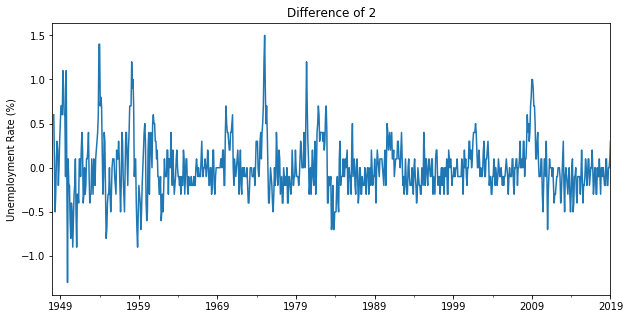

In [7]:
unrate_df['diff_2'] = unrate_df.UNRATE - unrate_df.UNRATE.shift(periods=2)
unrate_df['diff_2'].plot(kind='line', figsize=(10,5), title='Difference of 2')
plt.ylabel('Unemployment Rate (%)')
plt.show()

Differencing of 1 seems to look reasonably well, with some few moments of shocks earlier in the time frame. 

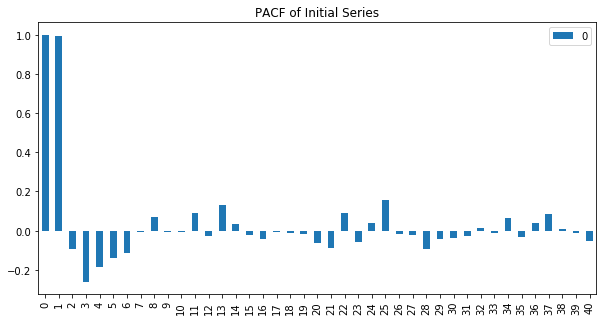

In [8]:
x_acf = pd.DataFrame(pacf(unrate_df.UNRATE))
x_acf.plot(kind='bar', figsize=(10,5), title='PACF of Initial Series')
plt.show()

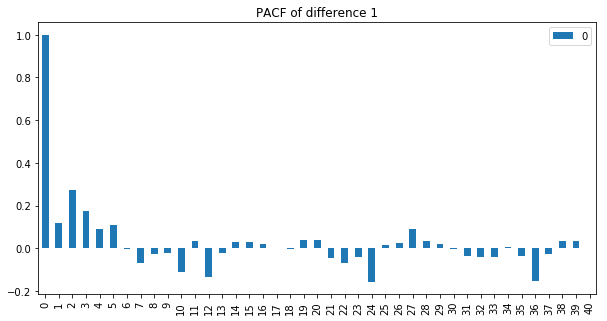

In [9]:
x_acf = pd.DataFrame(pacf(unrate_df.diff_1[1:]))
x_acf.plot(kind='bar', figsize=(10,5), title='PACF of difference 1')
plt.show()

The intial time series shows no good autocorrelation, but the PACF of the differencing of 1 shows some poetential for the order of 2. This means that the unemployment rate from 2 months ago has a decent effect in the unemployment rate of today. This is after the data has been made stationary. 

Let's generate some ARIMA models and see how well it fares. The parameters in consideration for an ARIMA(p,d,q) can be tested with p,d, and q representing the different portions of the ARIMA model. The p represents the order for the autoregression (AR) portion, the d represents the order for the integrated (I) portion, and the q represents the order for the moving average (MA) portion. 

The Autoregression (AR) represents the order for which preceding value we look at. An AR(1) model means we look at the initial series in comparison to the value before it and an AR(5) means that we compare the value in question with the value 5 periods behind it.

The Integrated (I) portion represents the order of differencing used when building the model. We can do this manually by providing the differenced series as we did above and set d to 0 or we can specify d as 1 and feed it the raw data. 

The Moving Averages (MA) portion represents the order by which the previous error in the predicted value compared to the real value affects the next forecasted option. Similar to the AR(n) model, the MA(n) represents how many n periods back we look at in order to see how its error affects the current error.

In [10]:
# Trying to see if we can ascertain the lag order thru AR(1) and MA(1) models, then iterating through other ARIMA models 
# by trial and error

ar_1 = ARIMA(unrate_df.UNRATE, order=(1,0,0))
model_fit = ar_1.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                 UNRATE   No. Observations:                  853
Model:                     ARMA(1, 0)   Log Likelihood                 125.376
Method:                       css-mle   S.D. of innovations              0.208
Date:                Sun, 24 Feb 2019   AIC                           -244.752
Time:                        20:14:48   BIC                           -230.505
Sample:                    01-01-1948   HQIC                          -239.295
                         - 01-01-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.2775      0.845      6.242      0.000       3.620       6.935
ar.L1.UNRATE     0.9924      0.004    247.605      0.000       0.985       1.000
                                    Roots   

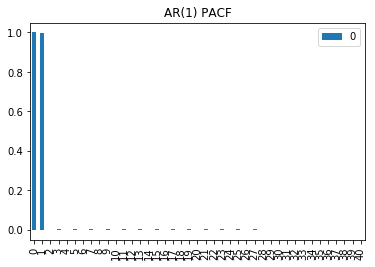

In [11]:
x_ar = [unrate_df.iloc[0, 1]]
for i in range(len(unrate_df.DATE)):
    y = 5.2775 + .9924*x_ar[i-1]
    x_ar.append(float(y))

x_acf = pd.DataFrame(pacf(x_ar[1:]))
x_acf.plot(kind='bar')
plt.title("AR(1) PACF")
plt.show()

In [12]:
ma_1 = ARIMA(unrate_df.UNRATE, order=(0,0,1))
model_fit = ma_1.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                 UNRATE   No. Observations:                  853
Model:                     ARMA(0, 1)   Log Likelihood               -1105.741
Method:                       css-mle   S.D. of innovations              0.883
Date:                Sun, 24 Feb 2019   AIC                           2217.483
Time:                        20:14:48   BIC                           2231.729
Sample:                    01-01-1948   HQIC                          2222.939
                         - 01-01-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.7576      0.059     97.886      0.000       5.642       5.873
ma.L1.UNRATE     0.9457      0.010     91.012      0.000       0.925       0.966
                                    Roots   

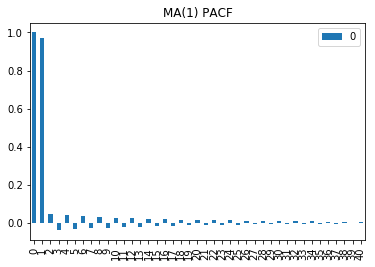

In [13]:
x_ma = [unrate_df.iloc[0, 1]]
for i in range(len(unrate_df.DATE)):
    y = 5.7576 + .9457*x_ma[i-1]
    x_ma.append(float(y))
    
x_acf = pd.DataFrame(pacf(x_ma))
x_acf.plot(kind='bar')
plt.title("MA(1) PACF")
plt.show()

## Iterating through ARIMA models through trial and error

In [14]:
# ARMA(1,1) model
arima_101 = ARIMA(unrate_df.UNRATE, order=(1,0,1))
model_fit = arima_101.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                 UNRATE   No. Observations:                  853
Model:                     ARMA(1, 1)   Log Likelihood                 129.501
Method:                       css-mle   S.D. of innovations              0.207
Date:                Sun, 24 Feb 2019   AIC                           -251.003
Time:                        20:14:49   BIC                           -232.008
Sample:                    01-01-1948   HQIC                          -243.728
                         - 01-01-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.3279      0.794      6.713      0.000       3.772       6.883
ar.L1.UNRATE     0.9912      0.004    225.946      0.000       0.983       1.000
ma.L1.UNRATE     0.0806      0.028      2.86

In [15]:
# ARIMA(1,1,1) model
arima_111 = ARIMA(unrate_df.UNRATE, order=(1,1,1))
model_fit = arima_111.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.UNRATE   No. Observations:                  852
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 165.812
Method:                       css-mle   S.D. of innovations              0.199
Date:                Sun, 24 Feb 2019   AIC                           -323.623
Time:                        20:14:49   BIC                           -304.633
Sample:                    02-01-1948   HQIC                          -316.350
                         - 01-01-2019                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0015      0.015      0.103      0.918      -0.028       0.031
ar.L1.D.UNRATE     0.8708      0.029     29.528      0.000       0.813       0.929
ma.L1.D.UNRATE    -0.7164      0.038

In [16]:
arima_112 = ARIMA(unrate_df.UNRATE, order=(1,1,2))
model_fit = arima_112.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.UNRATE   No. Observations:                  852
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 184.168
Method:                       css-mle   S.D. of innovations              0.195
Date:                Sun, 24 Feb 2019   AIC                           -358.337
Time:                        20:14:49   BIC                           -334.599
Sample:                    02-01-1948   HQIC                          -349.245
                         - 01-01-2019                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0017      0.015      0.114      0.909      -0.027       0.031
ar.L1.D.UNRATE     0.8177      0.037     22.278      0.000       0.746       0.890
ma.L1.D.UNRATE    -0.8110      0.048

In [17]:
# ARIMA(2,1,1) model
arima_211 = ARIMA(unrate_df.UNRATE, order=(2,1,1))
model_fit = arima_211.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.UNRATE   No. Observations:                  852
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 182.498
Method:                       css-mle   S.D. of innovations              0.195
Date:                Sun, 24 Feb 2019   AIC                           -354.997
Time:                        20:14:49   BIC                           -331.259
Sample:                    02-01-1948   HQIC                          -345.905
                         - 01-01-2019                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0017      0.015      0.114      0.909      -0.028       0.031
ar.L1.D.UNRATE     0.5655      0.062      9.106      0.000       0.444       0.687
ar.L2.D.UNRATE     0.2317      0.037

## Attempting to programatically find a good order through mean squared error in prediciton

In [18]:
#evaluating the many ARIMA models based on RMSE
split = int(len(unrate_df.DATE)*.7)
train = unrate_df.iloc[:split]
test = pd.DataFrame(unrate_df.iloc[split:, 1].reset_index())
def evaluate_arima(order):
    arima = ARIMA(train.UNRATE, order=order)
    model_fit = arima.fit()
    # setting up in-sample predictions. set type='levels' in order to return predictions in oridinal scale in case we use 
    # differencing
    pred = model_fit.predict(start=split, end=int(len(unrate_df))-1, typ= 'levels')
    #for i in range(len(pred)):
    #    print("Expected: {} Predicted: {:.3f}".format(test.iloc[i, 1], pred[i]))
    error = mse(test.UNRATE, pred)
    return [str(order), error]

In [19]:
def best_model_params(limit=1):
    best_mse, best_param=100000, None
    for p in range(limit):
        for d in range(limit):
            for q in range(limit):
                try:
                    result = evaluate_arima([p,d,q])
                except:
                    continue
                if result[1]<best_mse:
                    best_mse=result[1]
                    best_param = [p,d,q]
    return "{:.3f}".format(best_mse), best_param

best_model_params(limit=3)

C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\sohai\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a

('3.155', [2, 1, 2])

In [28]:
arima_212 = ARIMA(unrate_df.UNRATE, order=[2,1,2])
model_fit = arima_212.fit()
pred = model_fit.predict(start=split, end=int(len(unrate_df))-1, typ= 'levels')
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.UNRATE   No. Observations:                  852
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 189.837
Method:                       css-mle   S.D. of innovations              0.194
Date:                Sun, 24 Feb 2019   AIC                           -367.675
Time:                        20:22:59   BIC                           -339.189
Sample:                    02-01-1948   HQIC                          -356.765
                         - 01-01-2019                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0016      0.012      0.140      0.889      -0.021       0.025
ar.L1.D.UNRATE     1.6540      0.040     41.849      0.000       1.577       1.732
ar.L2.D.UNRATE    -0.7779      0.044

In [30]:
mse(test, pred)

0.020491016654141506

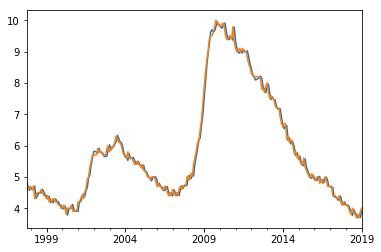

In [21]:
test = unrate_df.iloc[split:, 1]
pred.plot(kind='line')
test.plot(kind='line')
plt.show()

In [33]:
arima_101 = ARIMA(unrate_df.UNRATE, order=[1,0,1])
model_fit = arima_101.fit()
pred = model_fit.predict(start=split, end=int(len(unrate_df))-1)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                 UNRATE   No. Observations:                  853
Model:                     ARMA(1, 1)   Log Likelihood                 129.501
Method:                       css-mle   S.D. of innovations              0.207
Date:                Sun, 24 Feb 2019   AIC                           -251.003
Time:                        20:25:27   BIC                           -232.008
Sample:                    01-01-1948   HQIC                          -243.728
                         - 01-01-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.3279      0.794      6.713      0.000       3.772       6.883
ar.L1.UNRATE     0.9912      0.004    225.946      0.000       0.983       1.000
ma.L1.UNRATE     0.0806      0.028      2.86

In [34]:
mse(test, pred)

0.02437027189563963

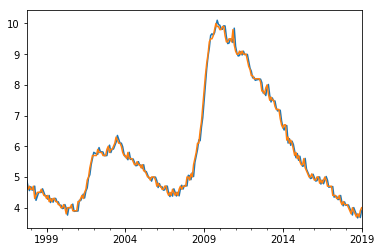

In [27]:
pred.plot(kind='line')
test.plot(kind='line')
plt.show()

From selecting the model based on mean squared error, we see that ARIMA(2,1,2) performs the best, but when we look at AIC and BIC from the previous iterations, we see that ARMA(1,1) and ARIMA(1,1,1) perferm wel